In [12]:
'''
    Convolutional neural network
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
criterion = nn.MSELoss()

inputs = torch.randn(1,1,32,32, requires_grad=True)


optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer.zero_grad()
out = net(inputs)
target = torch.arange(1,11)
target = target.view(1,-1)
loss = criterion(out, target)
loss.backward()
optimizer.step()

In [17]:

'''
    POS tagging 
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


def preparedata(seq, to_idx):
    if to_idx is word2idx:
        idxs = [to_idx[w.lower()] for w in seq]
    else:
        idxs = [to_idx[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

train_data = [
    ("the dog eat an apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"]),
    ("cat like fish".split(), ["NN", "V", "NN"]),
]

word2idx = set()
for seq, tags in train_data:
    for word in seq:
        word = word.lower()
        if word not in word2idx:
            word2idx.add(word)
word2idx = {word: idx for idx,word in enumerate(sorted(word2idx))}
tag2idx = {"DET": 0, "NN": 1, "V": 2}

# hyperparamters
HIDDEN_DIM = 16
EMBEDDING_DIM = 16


class MyLSTM(nn.Module):
    
    def __init__(self, Embedding_dim, Hidden_dim, vocab_size, target_size):
        super().__init__()
        self.hidden_dim = Hidden_dim
        self.embeds = nn.Embedding(vocab_size, Embedding_dim)
        self.lstm = nn.LSTM(input_size=Embedding_dim, hidden_size=self.hidden_dim)
        self.hidden2tag = nn.Linear(self.hidden_dim, target_size)
        self.hidden = self.init_hidden()
    
    def forward(self, sentence):
        embeds = self.embeds(sentence)
        lstm_outputs, self.hidden = self.lstm(embeds.view(len(sentence),1,-1), self.hidden)
        tag_space = self.hidden2tag(lstm_outputs.view(len(sentence),-1))
        tag_score = F.log_softmax(tag_space, dim=1)
        return tag_score
    
    def init_hidden(self):
        return (torch.zeros(1,1,self.hidden_dim),
                torch.zeros(1,1,self.hidden_dim))
    
model = MyLSTM(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), len(tag2idx))

loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

with torch.no_grad():
    inputs = preparedata(train_data[1][0], word2idx)
    tag_scores = model(inputs)
    print(tag_scores)
    
print('train start')
for i in range(300):
    for sentence, tags in train_data:
        model.zero_grad()
        model.hidden = model.init_hidden()
        
        inputs = preparedata(sentence, word2idx)
        targets = preparedata(tags, tag2idx)
        
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print("epoch:{}, loss:{}".format(i, loss.item()))
print('train done')

with torch.no_grad():
    inputs = preparedata(train_data[1][0], word2idx)
    tag_scores = model(inputs)
    print(tag_scores)
    print(np.argmax(np.exp(tag_scores), axis=1))

tensor([[-0.9189, -1.2199, -1.1849],
        [-0.8869, -1.3236, -1.1335],
        [-0.8511, -1.2644, -1.2356],
        [-0.8072, -1.3592, -1.2140]])
train start
epoch:0, loss:1.2430949211120605
epoch:50, loss:0.6022355556488037
epoch:100, loss:0.08683717995882034
epoch:150, loss:0.027351120486855507
epoch:200, loss:0.014909886755049229
epoch:250, loss:0.009966205805540085
train done
tensor([[-7.0281, -0.0024, -6.4868],
        [-4.9816, -6.3414, -0.0087],
        [-0.0355, -3.6941, -4.6025],
        [-5.4978, -0.0047, -7.3821]])
tensor([ 1,  2,  0,  1])


vocab_size: 618
古诗样本数: 53
train start
epoch:0, loss:5.98
epoch:25, loss:4.52
epoch:50, loss:4.04
epoch:75, loss:3.51
epoch:100, loss:3.35
epoch:125, loss:2.86
epoch:150, loss:2.56
epoch:175, loss:2.26
epoch:200, loss:2.01
epoch:225, loss:1.79
epoch:250, loss:1.74
epoch:275, loss:2.28
epoch:300, loss:1.37
epoch:325, loss:1.28
train done, cost448.9701454639435s


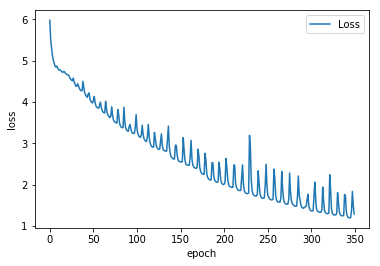

虽暮阴阳催短景，天涯霜回是前朝。
李白，碧水东流至扬州。孤帆一片日
娉月何处动吹，海看天地挂回朝。东
影开，江枫渔帘对江湖。


In [3]:
'''
    poetry-gen
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

word_dict = set()
raw_data = [
    '雨过横塘水满堤，乱山高下路东西。一番桃李花开尽，惟有青青草色齐。',
    '京口瓜洲一水间，钟山只隔数重山。春风又绿江南岸，明月何时照我还。',
    '茅檐长扫静无苔，花木成畦手自栽。一水护田将绿绕，两山排闼送青来。',
    '李白乘舟将欲行，忽闻岸上踏歌声。桃花潭水深千尺，不及汪伦送我情。',
    '朝辞白帝彩云间，千里江陵一日还。两岸猿声啼不住，轻舟已过万重山。',
    '天门中断楚江开，碧水东流至此回。两岸青山相对出，孤帆一片日边来。',
    '峨眉山月半轮秋，影入平羌江水流。夜发清溪向三峡，思君不见下渝州。',
    '故人西辞黄鹤楼，烟花三月下扬州。孤帆远影碧空尽，唯见长江天际流。',
    '杨花落尽子规啼，闻道龙标过五溪。我寄愁心与明月，随君直到夜郎西。',
    '百战沙场碎铁衣，城南已合数重围。突营射杀呼延将，独领残兵千骑归。',
    '越王句践破吴归，义士还乡尽锦衣。宫女如花满春殿，只今惟有鹧鸪飞。',
    '问余何意栖碧山，笑而不答心自闲。桃花流水窅然去，别有天地非人间。',
    '两个黄鹂鸣翠柳，一行白露上青天。窗含西岭千秋雪，门泊东吴万里船。',
    '三万里河东人海，五千仍岳上摩天。遗民泪尽胡尘里，南望王师又一年。',
    '曾经沧海难为水，除却巫山不是云。取次花丛懒回顾，半缘修道半缘君。',
    '去年今日此门中，人面桃花相映红。人面不知何处去，桃花依旧笑春风。',
    '多情却似总无情，唯觉樽前笑不成。蜡烛有心还惜别，替人垂泪到天明。',
    '青山隐隐水迢迢，秋尽江南草未凋。二十四桥明月夜，玉人何处教吹箫。',
    '公子王孙逐后尘，绿珠垂泪滴罗巾。侯门一入深似海，从此萧郎是路人。',
    '落魄江湖载酒行，楚腰纤细掌中轻。十年一觉扬州梦，赢得青楼薄幸名。',
    '岁岁金河复玉关，朝朝马策与刀环。三春白雪归青冢，万里黄河绕黑山。',
    '独在异乡为异客，每逢佳节倍思亲。遥知兄弟登高处，遍插茱萸少一人。',
    '日照香炉生紫烟，遥看瀑布挂前川。飞流直下三千尺，疑是银河落九天。',
    '寒雨连江夜入吴，平明送客楚山孤。洛阳亲友如相问，一片冰心在玉壶。',
    '闺中少妇不知愁，春日凝妆上翠楼。忽见陌头杨柳色，悔教夫婿觅封侯。',
    '葡萄美酒夜光杯，欲饮琵琶马上催。醉卧沙场君莫笑，古来征战几人回。',
    '独怜幽草涧边生，上有黄鹂深树鸣。春潮带雨晚来急，野渡无人舟自横。',
    '春城无处不飞花，寒食东风御柳斜。日暮汉宫传蜡烛，轻烟散入五侯家。',
    '玉楼天半起笙歌，风送宫嫔笑语和。月殿影开闻夜漏，水晶帘卷近秋河。',
    '朱雀桥边野草花，乌衣巷口夕阳斜。旧时王谢堂前燕，飞入寻常百姓家。',
    '新妆宜面下朱楼，深锁春光一院愁。行到中庭数花朵，蜻蜓飞上玉搔头。',
    '寂寂花时闭院门，美人相并立琼轩。含情欲说宫中事，鹦鹉前头不敢言。',
    '折戟沉沙铁未销，自将磨洗认前朝。东风不与周郎便，铜雀春深锁二乔。',
    '烟笼寒水月笼沙，夜泊秦淮近酒家。商女不知亡国恨，隔江犹唱后庭花。',
    '落魄江湖载酒行，楚腰纤细掌中轻。十年一觉扬州梦，赢得青楼薄幸名。',
    '银烛秋光冷画屏，轻罗小扇扑流萤。天阶夜色凉如水，坐看牵牛织女星。',
    '娉娉袅袅十三余，豆蔻梢头二月初。春风十里扬州路，卷上珠帘总不如。',
    '君问归期未有期，巴山夜雨涨秋池。何当共剪西窗烛，却话巴山夜雨时。',
    '嵩云秦树久离居，双鲤迢迢一纸书。休问梁园旧宾客，茂陵秋雨病相如。',
    '云母屏风烛影深，长河渐落晓星沉。嫦娥应悔偷灵药，碧海青天夜夜心。',
    '江雨霏霏江草齐，六朝如梦鸟空啼。无情最是台城柳，依旧烟笼十里堤。',
    '别梦依依到谢家，小廊回合曲阑斜。多情只有春庭月，犹为离人照落花。',
    '近寒食雨草萋萋，著麦苗风柳映堤。等是有家归未得，杜鹃休向耳边啼。',
    '别梦依依到谢家，小廊回合曲阑斜。多情只有春庭月，犹为离人照落花。',
    '岁暮阴阳催短景，天涯霜雪霁寒霄。五更鼓角声悲壮，三峡星河影动摇。',
    '燕台一去客心惊，箫鼓喧喧汉将营。万里寒光生积雪，三边曙色动危旌。',
    '沙场烽火侵胡月，海畔云山拥蓟城。少小虽非投笔吏，论功还欲请长缨。',
    '独怜幽草涧边生，上有黄鹂深树鸣。春潮带雨晚来急，野渡无人舟自横。',
    '月落乌啼霜满天，江枫渔火对愁眠。姑苏城外寒山寺，夜半钟声到客船。',
    '回乐峰前沙似雪，受降城外月如霜。不知何处吹芦管，一夜征人尽望乡。',
    '红树青山日欲斜，长郊草色绿无涯。游人不管春将老，来往亭前踏落花。',
    '夜凉吹笛千山月，路暗迷人百种花。棋罢不知人换世，酒阑无奈客思家。',
    '胜败兵家事不期，包羞忍耻是男儿。江东子弟多才俊，卷土重来未可知。',
]

first_char = set()
for sentence in raw_data:
    first_char.add(sentence[0])
    first_char.add(sentence[18])
    for char in sentence:
        if char not in word_dict:
            word_dict.add(char)
word_dict.add('eof')
word2indx = {word:idx for idx,word in enumerate(sorted(word_dict))}
indx2word = {idx:word for idx,word in enumerate(sorted(word_dict))}
print('vocab_size:', len(word2indx))
print('古诗样本数:', len(raw_data))

def make_one_case(sentence) -> (torch.tensor, torch.tensor):
    sentence = list(sentence)
    sentence.append('eof')
    length = len(sentence)
    inputs = []
    targets = []
    for i in range(1, length):
        pre = sentence[i-1]
        nex = sentence[i]
        inputs.append(word2indx[pre])
        targets.append(word2indx[nex])
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

#print(make_one_case('李白乘舟将欲行，忽闻岸上踏歌声。桃花潭水深千尺，不及汪伦送我情。'))

class Net(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=self.hidden_size)
        self.fc1 = nn.Linear(self.hidden_size, vocab_size)
        
    def forward(self, sentence, hidden):
        seq_length = sentence.size()[0]
        embeds = self.embed(sentence).view(seq_length, 1, -1)
        lstm_out, hidden = self.lstm(embeds, hidden)
        output = F.relu(self.fc1(lstm_out.view(seq_length, -1)))
        output = F.log_softmax(output, dim=1)
        return output, hidden
        
    def init_hidden(self):
        return (torch.zeros(1,1,self.hidden_size),
                torch.zeros(1,1,self.hidden_size))
    
# hyperparameters
VOCAB_SIZE = len(word2indx)
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 64

model = Net(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.0001)
loss_function = nn.NLLLoss()

train = True
if os.path.exists('params.pkl'):
    model.load_state_dict(torch.load('params.pkl'))
    train = False
if train == False:
    ans = input(r'是否强制训练(Y/N):')
    if ans == 'Y' or ans == 'y':
        train = True


# SGD batch_size=1
if train:
    print('train start')
    epoch = 350
    batch_size = len(raw_data)
    Loss = []
    start_time = time.time()
    for i in range(epoch):
        _loss = 0
        indxs = list(range(batch_size))
        random.shuffle(indxs)
        for j in indxs:
            inputs, targets = make_one_case(raw_data[j])
            model.zero_grad()
            hidden = model.init_hidden()
            outputs, hidden = model(inputs, hidden)
            loss = loss_function(outputs, targets)
            _loss += loss.item()
            loss.backward()
            optimizer.step()
        _loss /= batch_size
        if i % 25 == 0:
            print('epoch:{}, loss:{:.2f}'.format(i, _loss))
        Loss.append(_loss)
    end_time = time.time()
    print('train done, cost{}s'.format(end_time-start_time))
    torch.save(model.state_dict(), 'params.pkl')
    plt.plot(range(len(Loss)), Loss, label='Loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


def sample(startword, max_len=15) -> str:
    if startword not in word_dict:
        return 'null'
    inputs = torch.tensor([word2indx[startword]], dtype=torch.long)
    output_poetry = startword
    hidden = model.init_hidden()
    for i in range(max_len):
        outputs,hidden = model(inputs, hidden)
        topv, topi = outputs.data.topk(1)
        w = topi[0][0].item()
        word = indx2word[w]
        if word == 'eof':
            break
        else:
            output_poetry += word
        inputs = torch.tensor([w], dtype=torch.long)
    return output_poetry

nums = 4
for i in range(nums):
    word = random.sample(list(first_char), 1)[0]
    print(sample(startword=word, max_len=15))

In [30]:
import random
random.randint(2,4)

3

In [26]:
import os

f = open('七言律诗.TXT', 'r')
new_lines = []
lines = f.readlines()
for i in range(len(lines)):
    if lines[i] == '\n':
        lines[i] = '*'
lines.insert(0, '*')
# print(lines[0],lines[1],lines[2])
new_content = ''.join(lines)
poetrys = new_content.split('*')[1:]
for poetry in poetrys:
    t = poetry.split('\n')[2:-1]
    new_lines.append(''.join(t))
print(new_lines[1])
f.close()

燕台一去客心惊，箫鼓喧喧汉将营。万里寒光生积雪，三边曙色动危旌。沙场烽火侵胡月，海畔云山拥蓟城。少小虽非投笔吏，论功还欲请长缨。
